### Time Series Analysis- GroupH - Assignment 2###

### Group H: Shenyi Mao, Yueting Jiang, Chenyu Zhao, Jose Ferreira###

#### Question 1####

In [ ]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
import statsmodels as sm
import pandas as pd


In [108]:
#Simulate AR(1) 
alpha=0.1 
beta = 0.3
sigma=0.005
T_list=[100,250,1250]
N = 2000


for T in T_list:
    alpha_sum = 0
    beta_sum = 0
    sigma_sum = 0
    for i in range(0,N):
        x0=alpha/(1-beta) 
        x=np.zeros(T+1) 
        x[0]=x0
        eps=np.random.normal(0.0,sigma,T)
        for i in range(1,T+1):
            x[i]=alpha+beta*x[i-1]+eps[i-1]
                
        y=x[0:T]
        yp=x[1:(T+1)]
        m=np.sum(y)/T
        mp=np.sum(yp)/T
        betaCMLE=np.inner(y-m,yp-mp)/np.inner(y-m,y-m)
        alphaCMLE=mp-betaCMLE*m
        sigmaCMLE=np.sqrt(np.inner(yp-betaCMLE*y-alphaCMLE,
                                  yp-betaCMLE*y-alphaCMLE)/T)

        alpha_sum += alphaCMLE
        beta_sum += betaCMLE
        sigma_sum += sigmaCMLE
                


    alpha_hat = alpha_sum / N
    beta_hat = beta_sum / N 
    sigma_hat = sigma_sum / N
    print("T = ", T, ",(alpha,beta,sigma) = " ,[alpha_hat,beta_hat,sigma_hat])

T =  100 ,(alpha,beta,sigma) =  [0.10241538058311464, 0.28312476213647214, 0.0049514904970677188]
T =  250 ,(alpha,beta,sigma) =  [0.10097452949004188, 0.29320326339540786, 0.0049713902146183864]
T =  1250 ,(alpha,beta,sigma) =  [0.10023299069636014, 0.29832697193039043, 0.0049939568100829893]


+ $ Comment$

+ We run simulations N(=2000) times to give T(=100,250,1250) observations from the given AR(1) model and then fit the observartions into AR(1) to give the average MLE estimates. 
+ The output is: 
$$ T = 100, [\hat \alpha , \hat \beta, \hat \sigma]=  [0.102415,0.283124,0.00495149] $$
$$ T = 250, [\hat \alpha , \hat \beta, \hat \sigma]=  [0.100974,0.293203,0.00497139] $$
$$ T = 1250, [\hat \alpha , \hat \beta, \hat \sigma]=  [0.100232,0.298326,0.00499396] $$
we can see that the estimates are biased compare with the given parameters 
$$ [\alpha ,\beta, \sigma] = [0.1,0.3,0.005 ]$$
+ for these biased estimates,we can see that when T goes larger, the bias get smaller because the error is O($\frac{1}{N}$),which means that they are consistant. 

#### Question 2####

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [37]:
def perform_adf_test(xt):
    """
    input:  a timeseries 
    output: outputs the statistic values from the ADF test  
    """
    test = adfuller(xt)
    print('ADF Statistic: %f' % test[0])
    print('p-value: %f' % test[1])
    for key, value in test[4].items():
        print('\t%s: %.3f' % (key, value))
    
def plot_series(eur, diff_rates):
    plt.figure()
    plt.plot(eur,label='EUR')
    plt.plot(diff_rates,label='Rates differential')
    plt.title('EUR/USD')
    plt.xlabel('Date')
    plt.ylabel('Last')
    plt.legend()
    plt.show()

def plot_coint_residual(u):
    plt.figure()
    plt.plot(u,label='Cointegrating residual')
    plt.title('EUR/USD - (FED-ECB)')
    plt.xlabel('Date')
    plt.ylabel('Last')
    plt.legend()
    plt.show()   

In [54]:
def perform_engle_granger_test(eur, diff_rates, coint_residual, confidence):
    """
    input:  the two series, a cointegrating residual vector and the level of confidence for the statistic tests
    output: True if the series are cointegrated  
    """
    # run Dickey-Fuller on each series separately to check if they are I(d).
    print("EURUSD")
    eur_p = perform_adf_test(eur)
    print("Diff")
    diff_p = perform_adf_test(diff_rates)
    # this should be stationary
    print("delta EURUSD")
    lagged_eur = eur.diff().dropna()
    lag_eur_p = perform_adf_test(lagged_eur)
        
    # this too should be stationary
    print("delta rates")
    lagged_rates = diff_rates.diff().dropna()
    lag_rates_p = perform_adf_test(lagged_rates)
    
     
    
    # test unit root on the cointegration residual process, this would need to be stationary to say there is cointegration
    print("u")
    perform_adf_test(coint_residual)
    test = adfuller(coint_residual)
    p_value=test[1]
    if (p_value>confidence):
        print("The cointegrating residual is not stationary")
        return False
    
    print ("The series are cointegrated")
    return True 


In [57]:
def problem_2():
    # Section 2.1: Perform a cointegration test
    # Read data and generate time series 
    eur = pd.read_excel('HW2_Data.xlsx', sheet_name = 'EUR', 
                        index_col=0, parse_dates=True, infer_datetime_format=True)
    fed = pd.read_excel('HW2_Data.xlsx', sheet_name = 'FEDL01', 
                        index_col=0, parse_dates=True, infer_datetime_format=True)
    ecb = pd.read_excel('HW2_Data.xlsx', sheet_name = 'EUORDEPOT', 
                        index_col=0, parse_dates=True, infer_datetime_format=True)
    
    diff = fed - ecb
    
    plot_series(eur, diff)
    eur_rates = eur['Last Price'].dropna()
    diff_interest_rates = diff['Last Price'].dropna()
    merged_data = pd.concat([eur_rates.rename('eur'), diff_interest_rates.rename('rates')], axis=1)
    print(merged_data.head())
    clean_data = merged_data.dropna()
    u = (clean_data['rates'] - clean_data['eur'])
    
    plot_coint_residual(u)

    perform_engle_granger_test(eur_rates, diff_interest_rates, u, confidence=0.05)
    
    
    
    

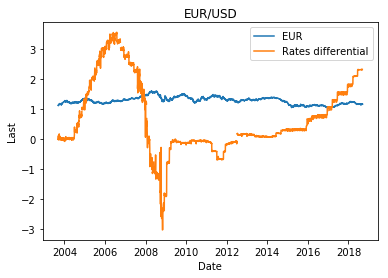

               eur  rates
Date                     
2003-09-11  1.1210   0.00
2003-09-12  1.1291   0.02
2003-09-15  1.1284   0.11
2003-09-16  1.1177  -0.03
2003-09-17  1.1285  -0.03


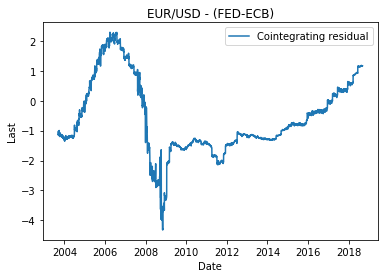

EURUSD
ADF Statistic: -1.966646
p-value: 0.301386
	5%: -2.862
	1%: -3.432
	10%: -2.567
Diff
ADF Statistic: -1.016293
p-value: 0.747276
	5%: -2.862
	1%: -3.432
	10%: -2.567
delta EURUSD
ADF Statistic: -62.279418
p-value: 0.000000
	5%: -2.862
	1%: -3.432
	10%: -2.567
delta rates
ADF Statistic: -9.600190
p-value: 0.000000
	5%: -2.862
	1%: -3.432
	10%: -2.567
u
ADF Statistic: -0.930077
p-value: 0.777906
	5%: -2.862
	1%: -3.432
	10%: -2.567
The cointegrating residual is not stationary


In [58]:
problem_2()

$Comment$

First, we run ADF on EURUUSD, the short interest difference  between Fed and ECB. The test result shows that both series are not stationary at 5% significance level. And the first difference of both series are stationary at 5% significance level. Thus we can conclude that both series are I(1).

Second, we use the given cointegration vector $\alpha=(1,-1)$ to calculate the residual of the cointegration process $u_t$. Then we test the stationarity of the reriduals. The test shows that the residual is not stationary at 5% significance level. Thus the vector $\alpha=(1,-1)$ is not the cointegration vector of EURUSD exchange rate and the differential between Fed and ECB short interest rates in these currencies.

#### Question 3####

We first calculate $p(x_1,x_2,\dots x_T|\theta, x_0)$

$$
p(x_1,x_2,\dots x_T|\theta, x_0)=\frac{1}{(2\pi \sigma^2)^{T/2}}\exp (-\frac{1}{2\sigma^2}\sum_{t=1}^{T}\epsilon_t^2)
$$

Note that $\hat{\epsilon_t }=x_t-\alpha-\beta x_{t-1}-\gamma_t$, follows $N(0,\sigma^2)$, thus
$$
p(x_1,x_2,\dots x_T|\theta, x_0)=\frac{1}{(2\pi \sigma^2)^{T/2}}\exp (-\frac{1}{2\sigma^2}\sum_{t=1}^{T}(x_t-\alpha-\beta x_{t-1}-\gamma_t)^2)
$$

the log-likelihood estimation:
$$
-\log L(\theta|y)=\frac{1}{2}T\log \sigma^2+\frac{1}{2\sigma^2}\sum_{t=1}^T(x_t-\hat{\alpha}-\hat{\beta}x_{t-1}-\hat{\gamma}t)^2+constant
$$

Minimizing this function yields:
\begin{align}
     \begin{bmatrix}
           \hat{\alpha} \\
           \hat{\beta} \\
           \hat{\gamma} 
       \end{bmatrix}
       =
       \begin{bmatrix}
           T&\sum_{t=1}^{T}x_{t-1} & \sum_{t=1}^{T}t \\
           \sum_{t=1}^{T}x_{t-1}&\sum_{t=1}^{T}x_{t-1}^2&\sum_{t=1}^{T}tx_{t-1}\\
           \sum_{t=1}^{T}t& \sum_{t=1}^{T}tx_{t-1}&\sum_{t=1}^{T}t^2
        \end{bmatrix}^{-1}
        \begin{bmatrix}
        \sum_{t=1}^{T}x_t\\
        \sum_{t=1}^{T}x_tx_{t-1}\\
        \sum_{t=1}^{T}t x_t
        \end{bmatrix}
  \end{align}
 $$ 
  \hat{\sigma}^2=\frac{1}{T}\sum_{t=1}^{T}(x_t-\hat{\alpha}-\hat{\beta}x_{t-1}-\hat{\gamma}t)^2
  $$